# Forecasting with Transformer

## Feng Li

### Guanghua School of Management
### Peking University

### [feng.li@gsm.pku.edu.cn](feng.li@gsm.pku.edu.cn)
### Course home page: [https://feng.li/forecasting-with-ai](https://feng.li/forecasting-with-ai)

In [1]:
pip install torch torchvision --break-system-packages

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## 生成时间序列数据
- 正弦波提供周期性规律（如季节性）
- 噪声代表现实中的随机波动（如市场波动）
- 这相当于我们要预测的“历史销售量”或“股票价格”

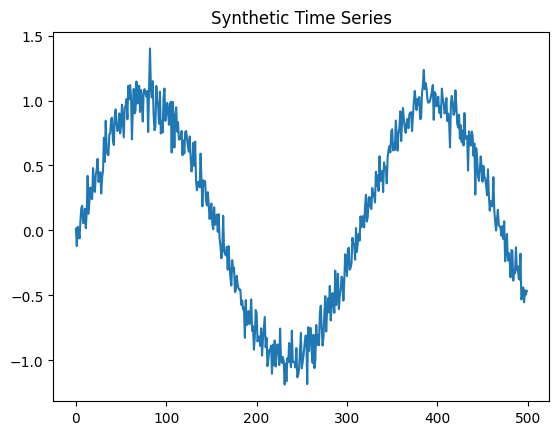

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣ Generate synthetic data
T = 500
t = np.arange(0, T)
x = np.sin(0.02 * t) + 0.1 * np.random.randn(T)

plt.plot(t, x)
plt.title("Synthetic Time Series")
plt.show()

# 转换成监督学习数据
- 我们把时间序列转成“特征—目标”形式。
- 每一段长度为 L=20 的历史数据是输入（X）；
- 之后的一个点是输出（Y）。

- 这就是把时间序列问题转化为机器学习能理解的监督学习任务。

In [3]:
# 2️⃣ Create supervised learning dataset
def create_dataset(series, L=20):
    X, Y = [], []
    for i in range(len(series) - L):
        X.append(series[i:i+L])
        Y.append(series[i+L])
    return np.array(X), np.array(Y)

L = 20
X, Y = create_dataset(x, L)
X = torch.tensor(X).float().unsqueeze(-1)  # (N, L, 1)
Y = torch.tensor(Y).float().unsqueeze(-1)  # (N, 1)

## 划分训练集与测试集
- 我们用前 80% 的数据训练模型（让它“学习规律”），

- 用后 20% 的数据做测试（检验它是否能“预测未来”）。

In [4]:
# 3️⃣ Split train/test
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 384, Test size: 96


# 定义 Transformer 模型

结构分三部分：

- 输入投影 (input_proj)：把标量数据（单个数）映射成“向量表示”；

- Transformer Encoder：捕捉序列中不同时间点之间的依赖关系；

- 解码层 (decoder)：输出未来一步的预测。

In [5]:
# 4️⃣ Define Transformer model
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_size=1, d_model=64, nhead=4, num_layers=2):
        super().__init__()
        self.input_proj = nn.Linear(input_size, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=128, dropout=0.1
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, src):
        src = self.input_proj(src)        # (batch, L, d_model)
        src = src.permute(1, 0, 2)        # (L, batch, d_model)
        memory = self.encoder(src)        # (L, batch, d_model)
        out = self.decoder(memory[-1])    # last token
        return out

## 参数解释

### `input_size = 1`：每个时间点的输入维度

* 每个时刻只有**一个特征**（比如销售量、价格、温度等）。
* 如果我们有多个特征（例如价格、销量、广告支出），`input_size` 就等于特征数，比如 3 或 5。


> 模型每次看到的“信息”只有一个数，就像只读“销售量”这一个指标。

> 每天你只看“销售额”这一个指标在变动，没有广告、价格、天气等额外信息。

### `d_model = 64`：内部表示的维度 (embedding dimension)

* Transformer 不直接处理原始数字，而是把每个输入映射到一个 **64维向量空间**；
* 这叫“特征嵌入（embedding）”，能让模型捕捉更复杂的模式；
* 越高维，模型表达能力越强，但计算量也更大。

🧠 **通俗理解：**

> 把一个数字转成 64 维的“语义向量”，模型在这个空间里找规律。
> 就像把“销售额”这个数转成一份更丰富的“销售特征报告”——里面包含周期性、波动趋势等 64 种特征维度。

### `nhead = 4`：注意力头（multi-head attention）数量

* Transformer 的核心是“多头注意力机制”；
* 每个 head 关注时间序列的不同方面，例如：

  * head 1 关注短期波动；
  * head 2 关注长期趋势；
  * head 3 关注异常跳动；
  * head 4 关注周期性。
* 多头机制能让模型**并行地捕捉多种依赖关系**。

🧠 **通俗理解：**

> 模型有 4 双“眼睛”，同时看时间序列的不同特征。
> 就像企业的 4 位分析师：一个看月度趋势、一个看季节波动、一个看假日效应、一个看竞争对手动态。

### `num_layers = 2`：Transformer 编码层的层数

* 每层都包含注意力机制和前馈网络；
* 层数越多，模型越“深”，可以捕捉更复杂的模式；
* 对于小数据（如示例），2 层就足够。

🧠 **通俗理解：**

> 模型有两层“思考单元”，先学到简单模式，再逐层抽象出更高层规律。
> 就像公司报告流程：一层是部门分析（第一层），另一层是高管总结（第二层），信息经过两轮加工变得更有洞察力。

## Q (Query), K (Key), V (Value) 在哪里？

在我们的这段代码中（`TimeSeriesTransformer`），虽然我们没有手动写出 Q、K、V 的矩阵，但它们其实**自动在 PyTorch 的 `TransformerEncoderLayer` 内部实现**了。

* 我们的 `src`（输入序列特征）会被线性投影到 Q、K、V 三个空间；
* `MultiheadAttention` 会并行计算多个头（我们设了 `nhead=4`）；
* 每个头独立生成自己的注意力权重；
* 然后所有头的结果会拼接起来，形成最终的注意力输出。

## 定义损失函数

* 创建一个 Transformer 模型对象；
    * 模型包含我们之前定义的结构（输入层 → 注意力层 → 解码层）；
    * 这个模型能从历史时间序列中“学习规律”，输出未来的预测。

* 定义损失函数（loss function），即模型预测误差的衡量方式；
    * `MSELoss` 表示 **均方误差（Mean Squared Error）**：
    * 损失越小，说明预测越准确。

* 定义**优化器（optimizer）**，控制模型如何学习、如何更新参数；
    * `Adam` 是一种自适应学习算法，能自动调整每个参数的学习步长；
    * `lr=1e-3` 表示学习率（learning rate）= 0.001，控制更新速度。

In [6]:
model = TimeSeriesTransformer()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

/home/fli/.virtualenvs/python3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


# 模型训练

我们用训练数据反复优化模型参数，让预测误差（MSE）最小。

- `loss` 衡量预测与真实值的差距；

- `optimizer` 用梯度下降更新模型；

- 每隔 20 轮，打印训练集与测试集误差。

In [7]:
# 5️⃣ Training loop
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, Y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 20 == 0:
        model.eval()
        with torch.no_grad():
            val_pred = model(X_test)
            val_loss = criterion(val_pred, Y_test)
        print(f"Epoch {epoch+1}: train loss={loss.item():.4f}, test loss={val_loss.item():.4f}")

Epoch 20: train loss=0.0328, test loss=0.0415
Epoch 40: train loss=0.0274, test loss=0.0225
Epoch 60: train loss=0.0220, test loss=0.0249
Epoch 80: train loss=0.0231, test loss=0.0236
Epoch 100: train loss=0.0214, test loss=0.0230


# 在测试集上预测

- 我们关闭训练（no_grad）
- 在没见过的数据上预测
- 模型用测试集输入（历史窗口），输出对应的下一步预测值

In [8]:
# 6️⃣ One-step ahead predictions on test set
model.eval()
with torch.no_grad():
    preds_test = model(X_test).squeeze().numpy()

## 可视化结果

- 蓝线：真实时间序列；

- 红线：测试期预测；

- 灰线：训练/测试分界线。

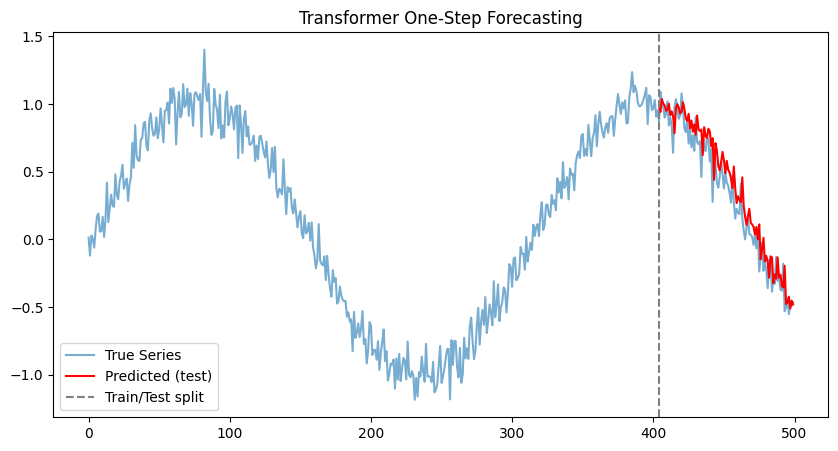

In [9]:
# 7️⃣ Plot true vs predicted on test portion
plt.figure(figsize=(10,5))
plt.plot(range(len(x)), x, label="True Series", alpha=0.6)
plt.plot(range(train_size+L, T), preds_test, label="Predicted (test)", color="red")
plt.axvline(train_size+L, color="gray", linestyle="--", label="Train/Test split")
plt.legend()
plt.title("Transformer One-Step Forecasting")
plt.show()